In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# My Functions:

In [4]:
def datetounix(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unixtime
    return(df)

# Importing all the Libraries at one go

In [7]:
# import libs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.ensemble import ExtraTreesClassifier
import operator
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# **Data Cleaning**

##### First task at hand is data cleaning. Loading Data from dataset and cleaning it up.

In [10]:
# read train dataframe
# file_path = os.path.join(os.path.abspath(''), '../input/train_aWnotuB.csv')
df_train = pd.read_csv('Train.csv', encoding='ISO-8859-1', engine='c')

# read test dataframe
# file_path = os.path.join(os.path.abspath(''), '../input/test_BdBKkAj.csv')
df_test = pd.read_csv('Test.csv', encoding='ISO-8859-1', engine='c')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  11808 non-null  object
 1   Junction  11808 non-null  int64 
 2   ID        11808 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 276.9+ KB


In [12]:
# Converting to datetime with dayfirst=True to handle DD/MM/YYYY format
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'], dayfirst=True)
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], dayfirst=True)

df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  11808 non-null  datetime64[ns]
 1   Junction  11808 non-null  int64         
 2   ID        11808 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 276.9 KB


In [14]:
# Creating features from DateTime for train data

df_test['Weekday'] = [datetime.weekday(date) for date in df_test.DateTime]
df_test['Year'] = [date.year for date in df_test.DateTime]
df_test['Month'] = [date.month for date in df_test.DateTime]
df_test['Day'] = [date.day for date in df_test.DateTime]
df_test['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_test.DateTime]
df_test['Week'] = [date.week for date in df_test.DateTime]
df_test['Quarter'] = [date.quarter for date in df_test.DateTime]

# Creating features from DateTime for test data

df_train['Weekday'] = [datetime.weekday(date) for date in df_train.DateTime]
df_train['Year'] = [date.year for date in df_train.DateTime]
df_train['Month'] = [date.month for date in df_train.DateTime]
df_train['Day'] = [date.day for date in df_train.DateTime]
df_train['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_train.DateTime]
df_train['Week'] = [date.week for date in df_train.DateTime]
df_train['Quarter'] = [date.quarter for date in df_train.DateTime]

# Analysis: To assess next steps

Feature ranking:
feature 0 : DateTime (0.368617)
feature 7 : Time (0.351152)
feature 6 : Day (0.067857)
feature 3 : Weekday (0.061792)
feature 1 : Junction (0.053574)
feature 2 : ID (0.053452)
feature 8 : Week (0.031456)
feature 5 : Month (0.007920)
feature 9 : Quarter (0.002301)
feature 4 : Year (0.001878)


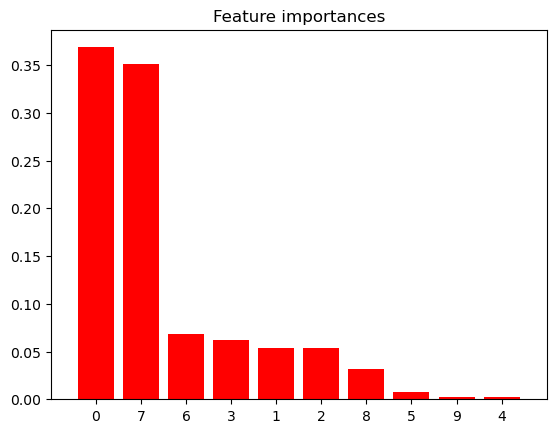

In [17]:
# create an instance for tree feature selection
tree_clf = ExtraTreesClassifier()

# first create arrays holding input and output data
# get the features into an array X
# remove target column from the df
df_train_features = df_train.drop(['Vehicles'], axis=1)

# Convet timestamp to seconds
df_train_features = datetounix(df_train_features)

# store features in X array
X = df_train_features.values

# Store target feature in y array
y = df_train['Vehicles'].values

# fit the model
tree_clf.fit(X, y)

# Preparing variables
importances = tree_clf.feature_importances_
feature_names = df_train_features.columns.tolist()

feature_imp_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

# Plot the feature importances of the forest
plt.figure(0)
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

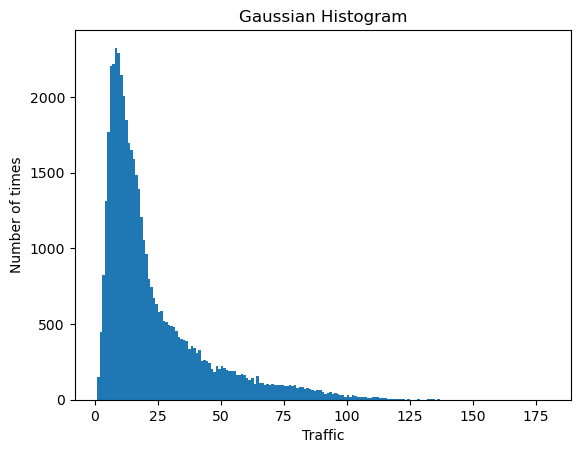

In [18]:
# Visualising the histogram for positive reviews only from train and dataset
data = df_train.Vehicles
binwidth = 1
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Traffic")
plt.ylabel("Number of times")
plt.show()

# Data Preparation:

In [27]:
######################################## X_test creation for Prediction #################################

# Convert timestamp to seconds
df_test_features = datetounix(df_test.drop(['Year', 'Quarter', 'Month', 'ID'], axis=1))

# Create X_test from the test set

X_test = df_test_features.values

######################################## Dropping Features from train set #######################

df_train_features = df_train.drop(['Vehicles','Year', 'Quarter', 'Month', 'ID'], axis=1)

# Convert timestamp to seconds
df_train_features = datetounix(df_train_features)

# store features in X array
X = df_train_features.values

# store target in y array
y = df_train['Vehicles'].values

# Using Decision Tree to Learn

In [29]:
# Data prep
df_solution = pd.DataFrame()
df_solution['ID'] = df_test.ID

# Starting time for time calculations
start_time = time.time()

# Create decision tree object
clf = DecisionTreeClassifier(criterion='gini', random_state = 13)

# fit the model
clf.fit(X, y)

# predict the outcome for testing data
predictions = clf.predict(X_test)

print("The time taken to execute is %s seconds" % (time.time() - start_time))

# Prepare Solution dataframe
df_solution['Vehicles'] = predictions
df_solution

The time taken to execute is 1.875300645828247 seconds


,ID,Vehicles
0,20170701001,70
1,20170701011,62
2,20170701021,52
3,20170701031,39
4,20170701041,40
...,...,...
11803,20171031194,30
11804,20171031204,30
11805,20171031214,16
11806,20171031224,22


In [31]:
df_pred = pd.DataFrame(df_solution)

In [33]:
df_pred['new_index'] = [n for n in range(48120, 59928)]

In [35]:
df_pred.set_index('new_index', inplace = True)
df = pd.merge(df_test.drop(['DateTime', 'Weekday', 'Year', 'Month', 'Day', 'Time', 'Week', 'Quarter'], axis = 1), df_pred, 
              how='inner', on = 'ID')
df.set_index(df_pred.index, inplace = True)
frames = [df_train.drop(['DateTime', 'Weekday', 'Year', 'Month', 'Day', 'Time', 'Week', 'Quarter'], axis = 1), df]
df = pd.concat(frames)
df

,Junction,Vehicles,ID
0,1,15,20151101001
1,1,13,20151101011
2,1,10,20151101021
3,1,7,20151101031
4,1,9,20151101041
...,...,...,...
59923,4,30,20171031194
59924,4,30,20171031204
59925,4,16,20171031214
59926,4,22,20171031224


<Axes: >

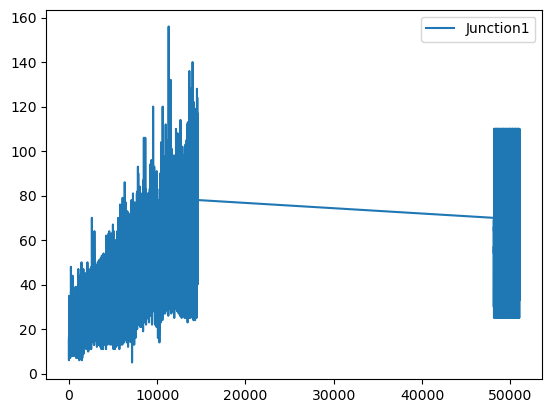

In [37]:
df[df['Junction'] == 1]['Vehicles'].plot(legend=True, label='Junction1')

<Axes: >

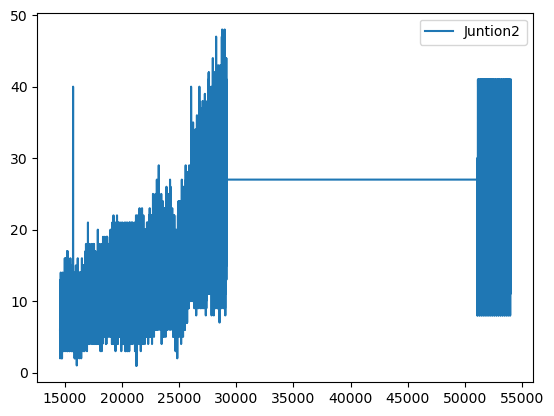

In [39]:
df[df['Junction'] == 2]['Vehicles'].plot(legend=True, label='Juntion2')

<Axes: >

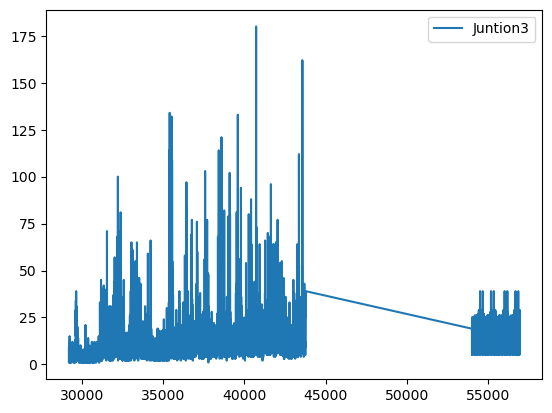

In [41]:
df[df['Junction'] == 3]['Vehicles'].plot(legend=True, label='Juntion3')

<Axes: >

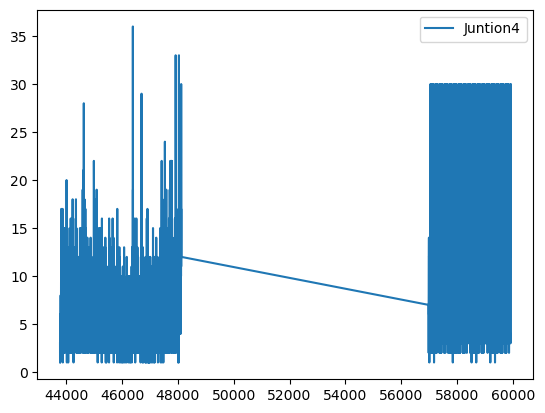

In [43]:
df[df['Junction'] == 4]['Vehicles'].plot(legend=True, label='Juntion4')

<Axes: xlabel='new_index'>

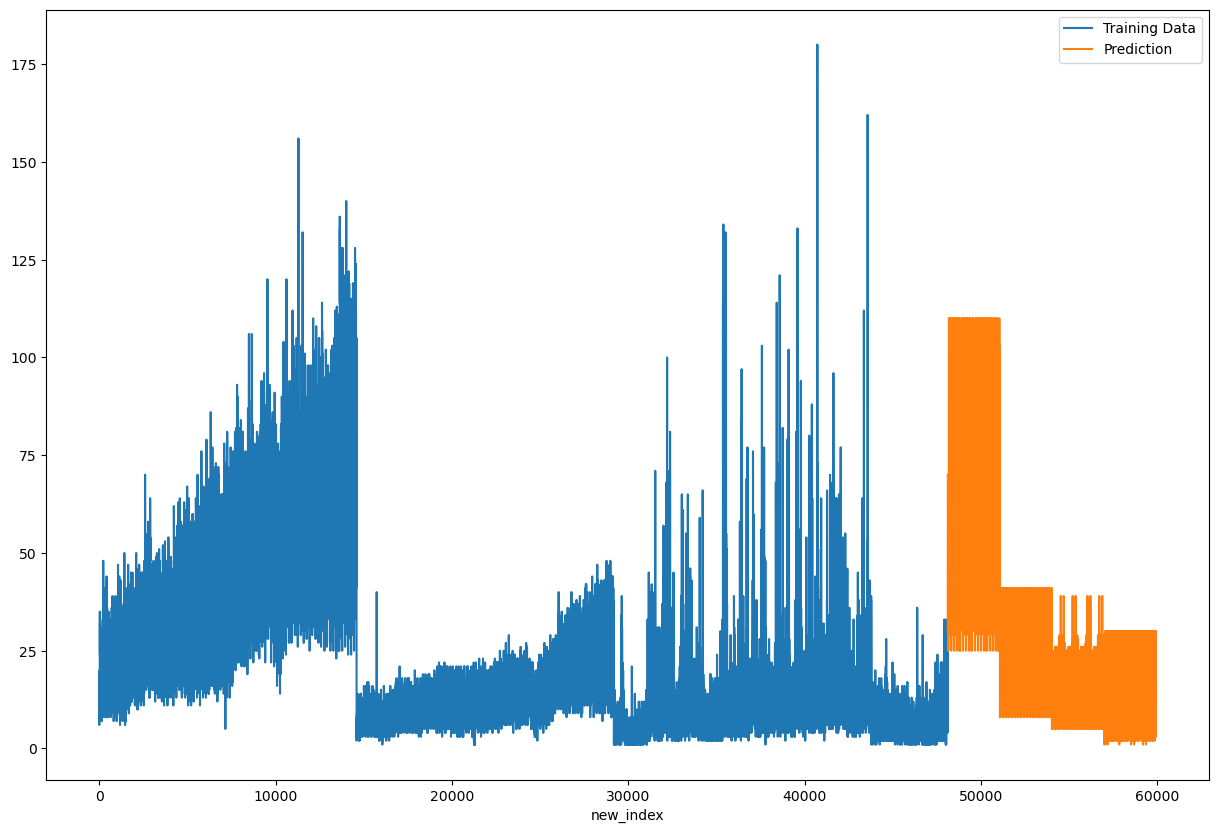

In [45]:
df_train['Vehicles'].plot(legend=True, label='Training Data', figsize=(15,10))
df_pred['Vehicles'].plot(legend=True, label='Prediction')

In [47]:
from sklearn.model_selection import train_test_split

In [49]:
# Example: create a copy first
df_train1 = df_train.copy()
df_train1['DateTime'] = pd.to_datetime(df_train1['DateTime'], dayfirst=True)

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Step 1: Ensure DateTime column is datetime type
df_train1['DateTime'] = pd.to_datetime(df_train1['DateTime'], dayfirst=True)

# Step 2: Extract datetime features
df_train1['Year'] = df_train1['DateTime'].dt.year
df_train1['Month'] = df_train1['DateTime'].dt.month
df_train1['Day'] = df_train1['DateTime'].dt.day
df_train1['Hour'] = df_train1['DateTime'].dt.hour
df_train1['Weekday'] = df_train1['DateTime'].dt.weekday

# Step 3: Drop the original DateTime column (if not needed directly)
df_train1 = df_train1.drop(columns=['DateTime'])

# Step 4: Split features and target
X = df_train1.drop(['Vehicles'], axis=1)
y = df_train1['Vehicles']

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Train the model
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

# Step 7: Predict and evaluate
pred = dtree.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, pred)))


MAE: 3.290870047104461
MSE: 26.888958160155166
RMSE: 5.1854564080855186


In [93]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


In [97]:
import joblib
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)  

joblib.dump(model, "vehicle_model.pkl")

['vehicle_model.pkl']